#IDC407- Network Science

###Group Project - Amazon Ratings

Group Members: Abhay Chand (MS20023), Shreyas Jain (MS20098), Sanjay AV (MS20047)

#1. Introduction

The aim of the this project was to pull down Amazon Ratings of different categories of products, and analyse their network attributes with the view of answering the following 3 questions:


1.   How can different categories of products be differentiated?
2.   In a category of products, what correlations can be drawn between the ratings of those products?
3. Can we exploit any network attributes to try and improve the overall ratings on the networks?

The Amazon Ratings network of any category of products is modelled as a bipartite graph, the nodes being partitioned into a consumer set (representing the reviewers) and a product set (representing the individual products). The edges between these sets are weighted with integer values 1-5 and correspond to the rating given by a consumer to a particular product.


#2. Methodology

To analyse a bipartite graph can prove more difficult then a regular graph, since many standard network attributes cannot be employed directly on a bipartite graph. However, we have employed the following two methods to circumvent these problems:



1.   Modified attributes: We've modified network attributes to operate only on one of the node sets
2.   Graph Projections: Bipartite graphs can also be projected onto one of their node sets, and this projected graph can be analysed instead. It is useful since standard network attributes can be applied, but it does result in a loss of information.

We pulled our data from [4]. In particular, we used the data labelled as "small subsets for experimentation" and used the rating only data. We considered the categories "All Beauty", "Magazine Subscriptions", and "Software". Data sets were chosen taking into consideration their size and to try and to incorporate seemingly related and diverse categories.



#3. Network Attributes Used

We used the following 3 attributes/ methods of analysis:



1.   Edge Weight Mulitplicity: This gives a histogram of edges, binned according to their weights. The reason to use this is that we expected different categories of products would give different results, i.e. in some categories of products there would be a tendency of ratings to mostly be high, and in other categories of products ratings would be more spread out.
2.   Modified Lorenz Curve: The Lorenze Curve, originally drawn from economics was a model to plot wealth distribution. However, as in [2] it can be used in networks to model the "wealth distribution of nodes", i.e. as a Cumulative Distibution Frequency of share of nodes with lowest degree vs the edges they are connected to. A straight line y=x represents all nodes having the same degree, and it is curved otherwise. We modify this to operate only on the product nodes, and plot the CDF of nodes (by average rating) vs the edges they are connected to. Our expectation was that more popular products could also be shown to be those which have higher average ratings.
3. A recommender system: We implement a recommender system.It works as follows: given a product/consumer, by taking the weighted projection of the product/consumer node set we can find highly related products/consumers and list them. Highly related consumers can be recommended the same product. Given an initial product X and a consumer who highly rates this product, other products which are highly related to X can be recommended to the consumer. Due to computational limitations, we are only able to take projections on the product nodes.



#4. Code Implementation

In this section we describe the code (through inline comments and text explanation) of the 4 functions used: the graph class, the lorenz curve plotter, the edge weight multiplicity and the recommender system. We also load our datasets for further use.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
# To use modified network attributes, we had to create a bipartite graph class
class Graph:
    def __init__(self,filename):
        self.file = pd.read_csv(filename).to_numpy()
        self.n = self.file.shape[0]

        #Sorting Items #Item
        self.pro1 = np.hstack(self.file[:,0])
        self.s1 = list(set(self.pro1))
        self.n1 = len(self.s1)

        #Sorting Customers #User
        self.pro2 = np.hstack(self.file[:,1])
        self.s2 = list(set(self.pro2))
        self.n2 = len(self.s2)

        #Normal Graph
        self.G = nx.Graph()

        # Add nodes with the node attribute "bipartite"

        self.G.add_nodes_from(self.s1, bipartite=0)

        self.G.add_nodes_from(self.s2, bipartite=1)

        for i in range(self.n):
            self.G.add_edges_from([(self.file[i,0], self.file[i,1],{'weight':self.file[i,2],'time':self.file[i,3]})])

        #Extracting nodes in two layers

        #Product Nodes
        self.top_nodes = {n for n, d in self.G.nodes(data=True) if d["bipartite"] == 0}

        #Customer Nodes
        self.bottom_nodes = set(self.G) - self.top_nodes





In [ ]:
def edge_multiplicity(name,data):
    #Plotting edge weight multiplicity
    weights = data[:,2]
    plt.hist(weights,range=(-0.5,5.5),bins=6) #simple histogram of edge weights
    plt.title(f'Edge Weight Multiplicity ({name})')
    plt.ylabel('Frequency')
    plt.xlabel('Rating')
    plt.show()

In [ ]:
def Lorenz_Curve(G,left_nodes):
    #Here we create our modified lorenz curve
    weights = {}
    time = {}
    for nd in left_nodes[:]: #left/ top nodes are the product nodes, looping through nodes
        a = G.edges([nd],data=True) #calling edges with weights of a particular node
        w = []
        t = []
        for i in a: #looping through edges connected to a particular node, this gives their weight and time of creation listed as tuples
            x,y,z = i
            w.append(z['weight']) #only interested in weights
            t.append(z['time'])
        weights[nd] = np.ones(len(w))*np.average(w)
# Here after finding the average weight of a node, we duplicate the node it by its degree. So if a node has degree 5 and average rating 3.4, we add 5 nodes of
#rating 3.4 to our node list. This allows our plotting function, which plots the CDF of frequency of nodes vs their average rating to actually plot the Lorenz curve,i.e.,
# the cdf of edges vs nodes sorted by average rating
    w = [] #list of nodes with duplications. E.g. [1.7,1.7,2,3,4.6] is a list of 4 nodes with their average ratings.
    for i in weights:
        w = w + list(weights[i])

    count, bins_count = np.histogram(w, range=(0,5),bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)

    x = np.linspace(0,1,100)

    plt.plot(bins_count[1:]/max(bins_count[1:]), cdf, label="CDF")
    plt.title('Lorenz Curve')
    plt.xlabel('Average Rating')
    plt.ylabel('Share of edges')
    plt.plot(x,x)
    plt.legend()
    plt.show()
    #plot idea: x axis: histogram of nodes binned according to average rating; y axis we duplicate a node by its degree. This essentially converts the y-value to the frequency of no of edges in the CDF (the actual function is frequency of nodes)

In [ ]:
#Recommender
def Recommender(G,left_nodes,right_nodes,id,product): #product==True - calculate related products, id- node name of consumer/product
    if product == True:
        R1 = nx.bipartite.weighted_projected_graph(G, left_nodes) #weighted product projection, left nodes are product ndes
        e = R1.edges(id,data=True) #calling prodducts related to the given product
        print('Related Products:')
        for i in e:
            print(i[1],i[2]) #returning the related product node as well as how strongly its connnected to the given product node
    else: #analogous but for consumers
        R2 = nx.bipartite.weighted_projected_graph(G, right_nodes) #we've created this for consumer projection, but it takes too long to run so we didn't use it
        e = R2.edges(id,data=True)
        print('Related Consumers:')
        for i in e:
            print(i[1],i[2])

In [ ]:
#Assigning the file locations and extracting the data
files = {'All_Beauty': r'C:\Users\abhay\OneDrive\Desktop\Everything\Coding\Python\Network_Science\Data\All_Beauty.csv','Magazine_Subscription':r'C:\Users\abhay\OneDrive\Desktop\Everything\Coding\Python\Network_Science\Data\Magazine_Subscriptions(1).csv','Software': r'C:\Users\abhay\OneDrive\Desktop\Everything\Coding\Python\Network_Science\Data\Software.csv'}

df = {}
for i in files:
  df[i] = pd.read_csv(files[i]).to_numpy()

#Colab was too slow to run code, so we had to do it locally.

#5. Network Analysis

In this section we show the implementation of our network analysis function and our results are demonstrated. We analyse our results in the next section.

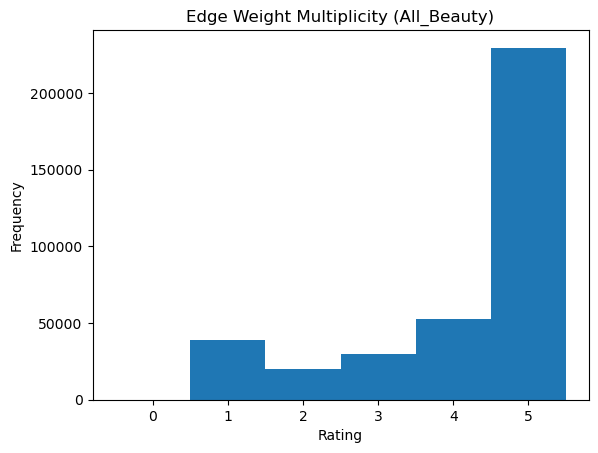

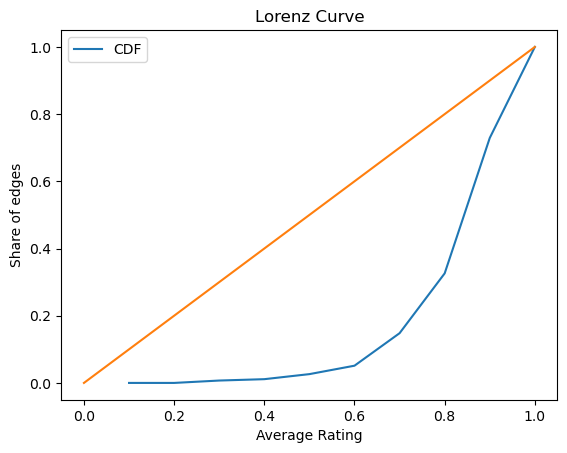

Related Products:
B00120VWTK {'weight': 2}
B00W2Y6TI4 {'weight': 1}
B0010ZBORW {'weight': 1}
B008UZSJ0A {'weight': 1}
B005DIQD00 {'weight': 1}
B0075ANCIK {'weight': 1}
B00ZL9Z1WM {'weight': 1}
B00NJ270ZY {'weight': 1}
B0002PU864 {'weight': 1}
B0006M56BK {'weight': 13}
B01C343CK0 {'weight': 1}
B00S8LDM1M {'weight': 1}
B0017I8Z6K {'weight': 1}
B001AS5PV0 {'weight': 1}
B011PIM56W {'weight': 1}
B001F51RAG {'weight': 3}
B00KHF4HCA {'weight': 4}
B002EF0FAE {'weight': 1}
B001F51WD8 {'weight': 1}
B01556PPTY {'weight': 4}
B004J0JAU8 {'weight': 1}
B001QY8QXM {'weight': 118}
B0013YXQ58 {'weight': 1}
B01BK6AITU {'weight': 1}
B000WZHGVY {'weight': 1}
B015G49M3K {'weight': 1}
B0068S6RXW {'weight': 1}
B00B7K0Z8E {'weight': 2}
B00KXKX4LO {'weight': 1}
B01D8030L4 {'weight': 1}
B00NV5SV70 {'weight': 1}
B00DT4757A {'weight': 1}
B01AS25Y0U {'weight': 1}
B00567UTKI {'weight': 1}
B004E3ION4 {'weight': 1}
B00NV6U3UC {'weight': 1}
B00C6CCD8C {'weight': 19}
B00NW5BWCK {'weight': 1}
B00GUGYA9U {'weight': 10}
B0

In [ ]:
#Analysing dataset 1 - All Beauty
Grp = Graph(files['All_Beauty'])
C = Grp.G
left_nodes = list(Grp.top_nodes)#product nodes
right_nodes = list(Grp.bottom_nodes)# consumer nodes

edge_multiplicity('All_Beauty',df['All_Beauty'])
Lorenz_Curve(C,left_nodes)
Recommender(C,left_nodes,right_nodes,product=True,id='1620213982') #a randomly chosen product id





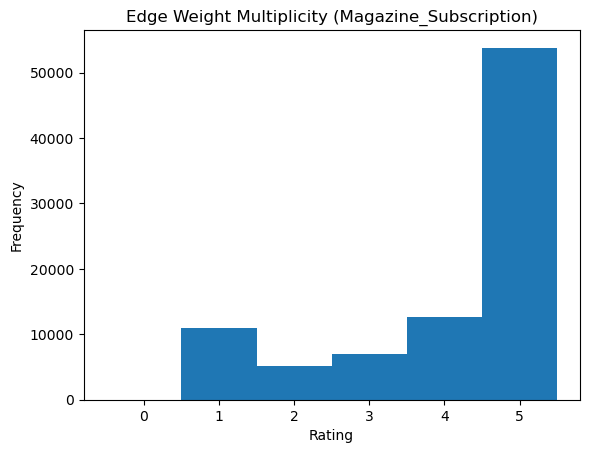

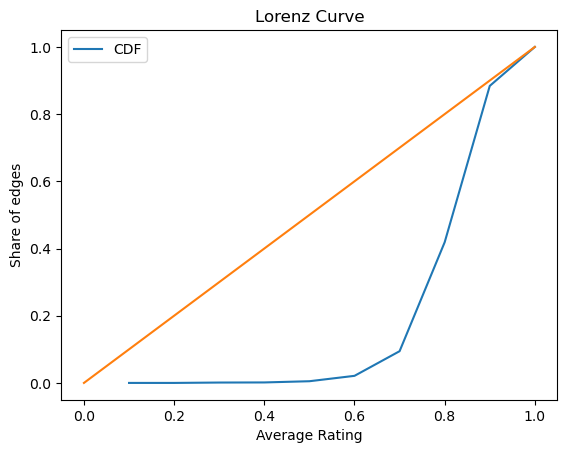

Related Products:
B00ENONLJ6 {'weight': 1}
B0000C4CU9 {'weight': 1}
B00005N7SA {'weight': 4}
B001GDJ4OS {'weight': 1}
B00006LIR1 {'weight': 1}
B00005NIPX {'weight': 1}
B00005V3E8 {'weight': 1}
B00005N7T3 {'weight': 1}
B00005UMOT {'weight': 1}
B00005N7U1 {'weight': 1}
B000NDESM0 {'weight': 4}
B00005N7SS {'weight': 1}
B00009MQ5Q {'weight': 1}
B00005NIOM {'weight': 1}
B00005N7QD {'weight': 1}
B00006KT0K {'weight': 1}
B000H1R14U {'weight': 1}
B00005NIRE {'weight': 1}
B00005N7S5 {'weight': 5}
B00005R8BL {'weight': 2}
B00007B1AI {'weight': 1}
B00005N7Q1 {'weight': 2}
B000EGCIW8 {'weight': 1}
B00005N7R0 {'weight': 1}
B00005NIN8 {'weight': 2}
B00008GT1F {'weight': 1}
B00005NIO2 {'weight': 1}
B00007AX0N {'weight': 1}
B000066T0G {'weight': 1}
B00005NIRS {'weight': 1}
B007ZUWNA8 {'weight': 1}
B00005N7TL {'weight': 13}
B00007AXQ2 {'weight': 1}
B00007AWME {'weight': 1}
B00005N7XO {'weight': 1}
B00005N7QS {'weight': 1}
B0058EONOM {'weight': 1}
B00006LKH1 {'weight': 1}
B00005N7S4 {'weight': 2}
B00005

In [ ]:
#Analysing dataset 2 - 'Magazine_Subscription'
Grp = Graph(files['Magazine_Subscription'])
C = Grp.G
left_nodes = list(Grp.top_nodes) #product nodes
right_nodes = list(Grp.bottom_nodes) #consumer nodes

edge_multiplicity('Magazine_Subscription',df['Magazine_Subscription'])
Lorenz_Curve(C,left_nodes)
Recommender(C,left_nodes,right_nodes,product=True,id='B00005N7P0') #randomly chosen product node"


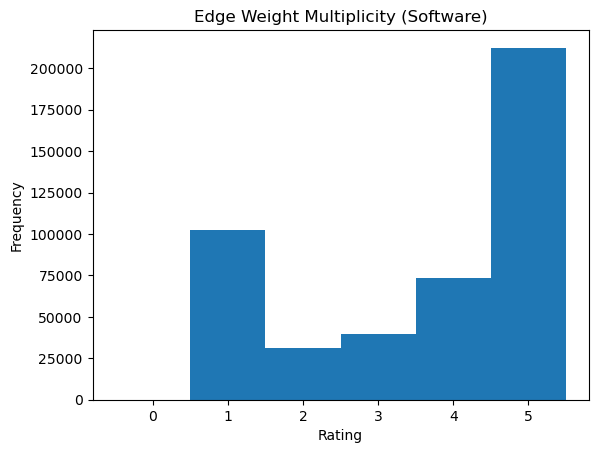

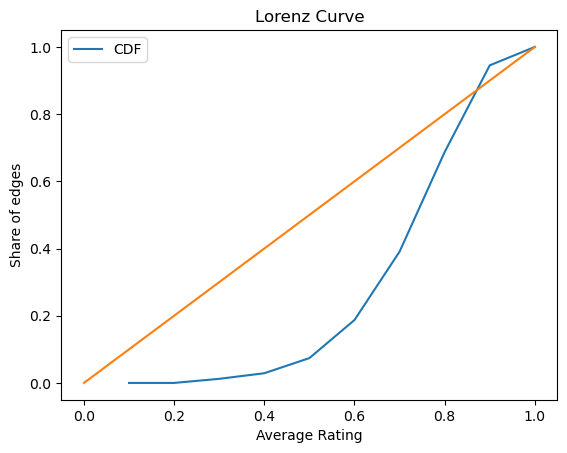

Related Products:
B0001WN0M2 {'weight': 1}
B001AFD8XK {'weight': 1}
B0007LW22G {'weight': 2}
B000ASG344 {'weight': 1}
B00M76N6MO {'weight': 1}
B000BX7H52 {'weight': 1}
B000BGZHD8 {'weight': 1}
B001EHXOFG {'weight': 1}
B0007LW22Q {'weight': 3}
B0001WN16M {'weight': 1}
B001BY45QO {'weight': 1}
B000GKSHI6 {'weight': 1}
B000QCTQN4 {'weight': 1}
B000BR0NPO {'weight': 1}
B00013WGZ8 {'weight': 1}
B0064PFB9U {'weight': 1}
B0043T4IQ6 {'weight': 1}
B000HLT5SA {'weight': 1}
B002KIIKCU {'weight': 1}
B00IDQ1W32 {'weight': 1}
B001F5VBRU {'weight': 1}
B0007LW23A {'weight': 1}
B000BW3TK0 {'weight': 1}
B0002NT83U {'weight': 1}


In [ ]:
#Analysing dataset 3 - Software
Grp = Graph(files['Software'])
C = Grp.G
left_nodes = list(Grp.top_nodes) #product nodes
right_nodes = list(Grp.bottom_nodes) #consumer nodes

edge_multiplicity('Software',df['Software'])
Lorenz_Curve(C,left_nodes)
Recommender(C,left_nodes,right_nodes,product=True,id='B0008GLGEA') #randomly chosen product node

#6. Result Discussion



1.   Edge weight multiplicity: We see that the edge weight multiplicity for "All Beauty" and "Magazine Subscription" are similar, both have mostly high ratings in the network. However, in the "Software" category there are a significant number of 1/5 ratings, almost as half as many as the the 5/5 ratings. Thus edge weight multiplicity seems to be a suitable network attribute to differentiate different categories of products. A suitable explanation is this: Some categories (which are more subjective), it is hard for people to converge negatively on any particular product. For example a particular beauty product such as a perfume can be hard to negatively rate, since taste is subjective and in general most perfumes do enhance smell. Similarly for magazine subscriptions, a person would subscribe to a magazine only if they liked the general coverage of the magazine. We can classify these as 'hard to dislike' products. However as we can see in software, the presence of a large amount of negative ratings implies that a software product can be heavuly disliked. It may be clunky, slow, RAM hungry, etc. Even though these vary from person to person, it is rather straightforward to dislike a software product explaining the high 1/5 edge multiplicity.   
2.   Modified Lorenz Curve: In all 3 categories we see that the portion of nodes with highest average rating also have the highest share of edges. In particular, we see that products with an average rating of 4/5 or higher take up most of the edges in the graph. Thus our hypothesis of the most popular (having most number of ratings) products also being the most highly rated products holds up, and we establish a direct correlation between the popularity of a product and its average rating.

Finally, we note that our recommender system functions properly. Since an edge may not exist between a recommended product to a particular consumer (since we would recommend products the consumer has not rated before) there isn't much more to analyse. To recapitulate, the idea was highly related products in the product node projection are ones which are purchased by the same consumer. So if a consumer is known to purchase a particular product, we should recommend the consumer other products related to this one. An example is how on Amazon if you are looking to add a phone cover to your cart, it also recommends a screen cover for the same model to be added to your cart. A similar idea holds for consumer projections, but these are too large to calculate.

#7. Conclusion

The 3 questions we asked initially have all been answered. Edge weight multiplicity is a good attribute to differentiate categories of products. We saw the modified Lorenz curve esatblished a direct correlation between the rating of a product and its popularity. Finally, we implemented a recommender system which given a product finds highly related products (through a weighted projection) so that all of these can be recommended to a consumer who was interested in any one of these products.

#References



1.   http://konect.cc/networks/amazon-ratings/
2.   Kunegis, J. (2023). Handbook of Network Analysis: The KONECT Project. https://raw.githubusercontent.com/kunegis/konect-handbook/master/konect-handbook.pdf
3.  https://ericmjl.github.io/Network-Analysis-Made-Simple/04-advanced/01-bipartite/
4.  https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/



Group Contributions:

1. Abhay Chand (MS20023): Built and tested the code, loaded data sets, assistance in result analysis/ network attribute selection (50% contribution)
2. Shreyas Jain (MS20098): Selected network attributes to be used, designed methodology, report writing and result analysis/discussion, assistance in code-writing (50% contribution)
3. Sanjay AV (MS20047): Chose not to contribute/ take part in the group project (0% contribution)